In [16]:
import qiskit as qk
from qiskit.primitives import Sampler
from random import randint
from numpy import pi

# Допоміжне
Нище наведено декоратор для більш зручного використання квантових схем. Конкретніше, цей декоратор дозволяє перетворити функцію, що повертає схему, у функцію, що повертає результат викоритання схеми.

In [2]:
# Decorator for running circuits
def run_circuit(circuit_function):
    def wrapper(*args, **kwargs):
        circuit = circuit_function(*args, **kwargs)
        sampler = Sampler()
        job = sampler.run(circuits=[circuit])
        result = job.result()
        return result
    return wrapper

# Тоффолі та Марголус
## Марголус
Нище наведена схема та відповідна реалізація вентиля Марголуса.

![alt text](Images/Margolus.png)

In [3]:
@run_circuit
def Margolus(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.ry(pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(pi/4, 2)
    circuit.cx(0, 2)
    circuit.ry(-pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(-pi/4, 2)
    circuit.measure(2, 0)
    return circuit

## Тоффолі
Нище наведено схему та відповідну реалізацію вентиля Тоффолі.

![alt text](Images/Toffoli.png)

In [4]:
@run_circuit
def Toffoli(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.h(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t([1, 2])
    circuit.h(2)
    circuit.cx(0, 1)
    circuit.tdg(1)
    circuit.t(0)
    circuit.cx(0, 1)
    circuit.measure(2, 0)
    return circuit

## Перевірка роботи
Необхідно провести перевірку роботи реалізацій вище щоб упевнитися в їх коректності.

In [13]:
for x in [0, 1]:
    for y in [0, 1]:
        for z in [0, 1]:
            real = (x & y) ^ z
            res_margolus = Margolus(x, y, z).quasi_dists[0].keys()
            res_toffoli = Toffoli(x, y, z).quasi_dists[0].keys()
            print(f"Expected answer for CCX({x},{y},{z}): " , real,"\n", 
                  "Margolus gate answer:\t\t", *res_margolus, "\n", 
                  "Toffoli gate answer:\t\t", *res_toffoli)

Expected answer for CCX(0,0,0):  0 
 Margolus gate answer:		 0 
 Toffoli gate answer:		 0
Expected answer for CCX(0,0,1):  1 
 Margolus gate answer:		 0 
 Toffoli gate answer:		 0
Expected answer for CCX(0,1,0):  0 
 Margolus gate answer:		 0 
 Toffoli gate answer:		 0
Expected answer for CCX(0,1,1):  1 
 Margolus gate answer:		 1 
 Toffoli gate answer:		 1
Expected answer for CCX(1,0,0):  0 
 Margolus gate answer:		 1 
 Toffoli gate answer:		 1
Expected answer for CCX(1,0,1):  1 
 Margolus gate answer:		 1 
 Toffoli gate answer:		 1
Expected answer for CCX(1,1,0):  1 
 Margolus gate answer:		 1 
 Toffoli gate answer:		 1
Expected answer for CCX(1,1,1):  0 
 Margolus gate answer:		 0 
 Toffoli gate answer:		 0


Як бачимо, реалізовані схеми дійсно обчислюють шукані значення.

# Квантова схема додавання
## Допоміжні вентилі
Для реалізації квантової схеми додавання двох невід'ємних чисел, спочатку необхідно (для спрощення роботи) реалізувати наступні три схеми.

### Схема біту переносу
Схема нище використовуються для обрахунку біту переносу.

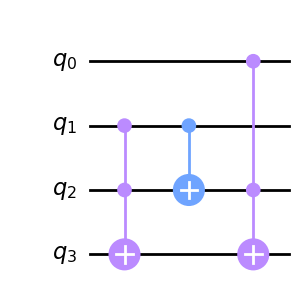

In [18]:
CarryGate = qk.QuantumCircuit(4, name="Carry")
CarryGate.ccx(1, 2, 3)
CarryGate.cx(1, 2)
CarryGate.ccx(0, 2, 3)
CarryGate.draw(output="mpl", style="clifford")

### Зворотня схема до схеми біту переносу
Схема нище необхідна для обернення обчислень, що були проведені за допомогою схеми біту переносу. 

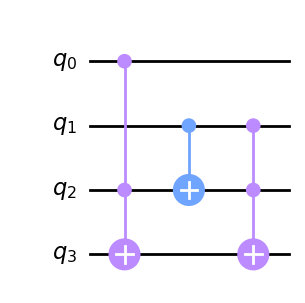

In [19]:
InverseCarryGate = qk.QuantumCircuit(4, name="InverseCarry")
InverseCarryGate.ccx(0, 2, 3)
InverseCarryGate.cx(1, 2)
InverseCarryGate.ccx(1, 2, 3)
InverseCarryGate.draw(output="mpl", style="clifford")

### Вентиль додавання
Схема нище проводить додавання однобітових чисел з урахуванням біту переносу.

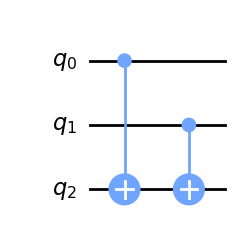

In [20]:
SumGate = qk.QuantumCircuit(3, name="Sum")
SumGate.cx(0, 2)
SumGate.cx(1, 2)
SumGate.draw(output="mpl", style="clifford")

## Квантова схема додавання двох чисел
Нище наведена одна з можливих реалізацій квантової схеми додавання двох невід'ємних чисел. Саме ця схема була розглянута на парі та, зокрема, наведена у книжці "*Mikio Nakahara, Tetsuo Ohmi - Quantum Computing. From Linear Algebra to Physical Realizations*".

In [21]:
@run_circuit
def add(x, y):
    '''
    Adder circuit

    Args:
        x (int): First input
        y (int): Second input

    Returns:
        circuit (QuantumCircuit): Adder circuit
    '''

    global CarryGate, InverseCarryGate, SumGate
    assert 0 <= x and 0 <= y, "Invalid input"

    # Preprocessing
    x_str, y_str = map(lambda x: bin(x)[2:], [x, y])
    max_len = max(len(x_str), len(y_str))
    
    # Padding
    x_str = "0" * (max_len - len(x_str)) + x_str
    y_str = "0" * (max_len - len(y_str)) + y_str

    # Initializing carry bits
    carry_bits = []
    for i in range(max_len + 1):
        carry_bits.append(qk.QuantumRegister(1, name="c" + str(i)))
    
    # Initializing numbers
    x = [qk.QuantumRegister(1, name="x" + str(i)) for i in range(max_len)]
    y = [qk.QuantumRegister(1, name="y" + str(i)) for i in range(max_len)]

    # Initializing output bits
    s = [qk.ClassicalRegister(1, name="s" + str(i)) for i in range(max_len + 1)]

    # Initializing circuit
    init_list = []
    for i in range(max_len):
        init_list.extend([carry_bits[i], x[i], y[i]])
    init_list.append(carry_bits[max_len])
    init_list.extend(s)
    circuit = qk.QuantumCircuit(*init_list)

    # Initializing qbits
    for i in range(max_len):
        circuit.initialize(x_str[i], x[max_len - i - 1])
        circuit.initialize(y_str[i], y[max_len - i - 1])

    # Circuit itself
    for i in range(max_len):
        circuit.append(CarryGate, [carry_bits[i], x[i], y[i], carry_bits[i+1]])

    circuit.cx(x[-1], y[-1])

    circuit.append(SumGate, [carry_bits[-2], x[-1], y[-1]])
    for i in range(max_len - 2, -1, -1):
        circuit.append(InverseCarryGate, [carry_bits[i], x[i], y[i], carry_bits[i+1]])    
        circuit.append(SumGate, [carry_bits[i], x[i], y[i]])
    circuit.barrier()

    # Output
    result_qbits = list(map(lambda x: x[0], y)) + [carry_bits[-1][0]]
    output_bits = map(lambda x: x[0], s)
    circuit.measure(result_qbits, output_bits)
    return circuit

![alt text](Images/AdderCircuitExample.png)
<p align="center"><i>Приклад схеми для чисел 7 та 5</i></p>

### Перевірка роботи
Перевіримо правильність роботи схеми.

In [44]:
num_test = 10
for _ in range(num_test):
    x = randint(0, 31)
    y = randint(0, 31)
    print(f"Inputs: x = {x:>2}, y = {y}\t", "Real answer:", x + y, "\t", "Computed:", *add(x, y).quasi_dists[0])

Inputs: x = 24, y = 27	 Real answer: 51 	 Computed: 51
Inputs: x = 14, y = 11	 Real answer: 25 	 Computed: 25
Inputs: x = 26, y = 8	 Real answer: 34 	 Computed: 34
Inputs: x =  3, y = 27	 Real answer: 30 	 Computed: 30
Inputs: x = 20, y = 5	 Real answer: 25 	 Computed: 25
Inputs: x = 22, y = 22	 Real answer: 44 	 Computed: 44
Inputs: x = 18, y = 27	 Real answer: 45 	 Computed: 45
Inputs: x =  2, y = 7	 Real answer: 9 	 Computed: 9
Inputs: x = 20, y = 31	 Real answer: 51 	 Computed: 51
Inputs: x = 31, y = 5	 Real answer: 36 	 Computed: 36


Як бачимо, схема дійсно виконує додавання.